In [1]:
import numpy as np
import pandas as pd

# Load the CSV file, ignoring dtype warnings by setting low_memory=False
df = pd.read_csv('position_velocity_data.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep = df['real_timestep_s'].values[0]

# Convert them to numpy arrays
# positions = [df[col].astype(float).values for col in position_cols]
# velocities = [df[col].astype(float).values for col in velocity_cols]
positions = np.array([df[col].astype(float).values for col in position_cols])
velocities = np.array([df[col].astype(float).values for col in velocity_cols])

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
positions = np.array(positions)
velocities = np.array(velocities)

# Print the shapes to verify
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")


Positions shape: (1, 45469480)
Velocities shape: (1, 45469480)


In [2]:
bin_num = 1000
fs = 1/(timestep*bin_num)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in positions:
    series = bin_data(trace, bin_num)
    traces.append(series)

V_traces = []
for trace in velocities:
    series = bin_data(trace, bin_num)
    V_traces.append(series)

zero idx: [  133   153   435  1136  1296  1335  2019  2370  2737  2770  2829  3315
  3794  3985  4672  5063  5347  6086  6541  6887  7043  7223  7265  7331
  7677  7700  7701  7732  7919  8559  8565  8928  9284  9296  9338  9363
  9845 10268 10417 10847 11320 11701 11747 11801 12159 12473 13151 13153
 13807 13954 13998 13999 14071 14296 14930 14978 15176 15188 15295 15396
 16120 16383 16570 16676 16758 17175 17448 17457 17800 17813 17947 18426
 18428 18433 18555 18734 19208 19573 20005 20023 20027 21515 21693 21744
 22026 22414 22483 22856 23025 23028 23059 23308 23792 23931 24177 25120
 25510 25568 26311 26317 26348 26647 26679 26889 27153 27721 27763 27924
 28240 28518 28653 28982 29390 30139 30196 30657 30819 31072 31191 31215
 32266 32311 32372 32761 33232 33716 33942 34776 34793 34809 35914 35990
 36166 36222 36231 36352 36359 36674 36721 36768 37755 38268 38741 38851
 38852 39034 39036 39403 39499 39949 40603 40861 41041 41206 41323 41505
 41566 41574 41596 41726 41939 42526 4272

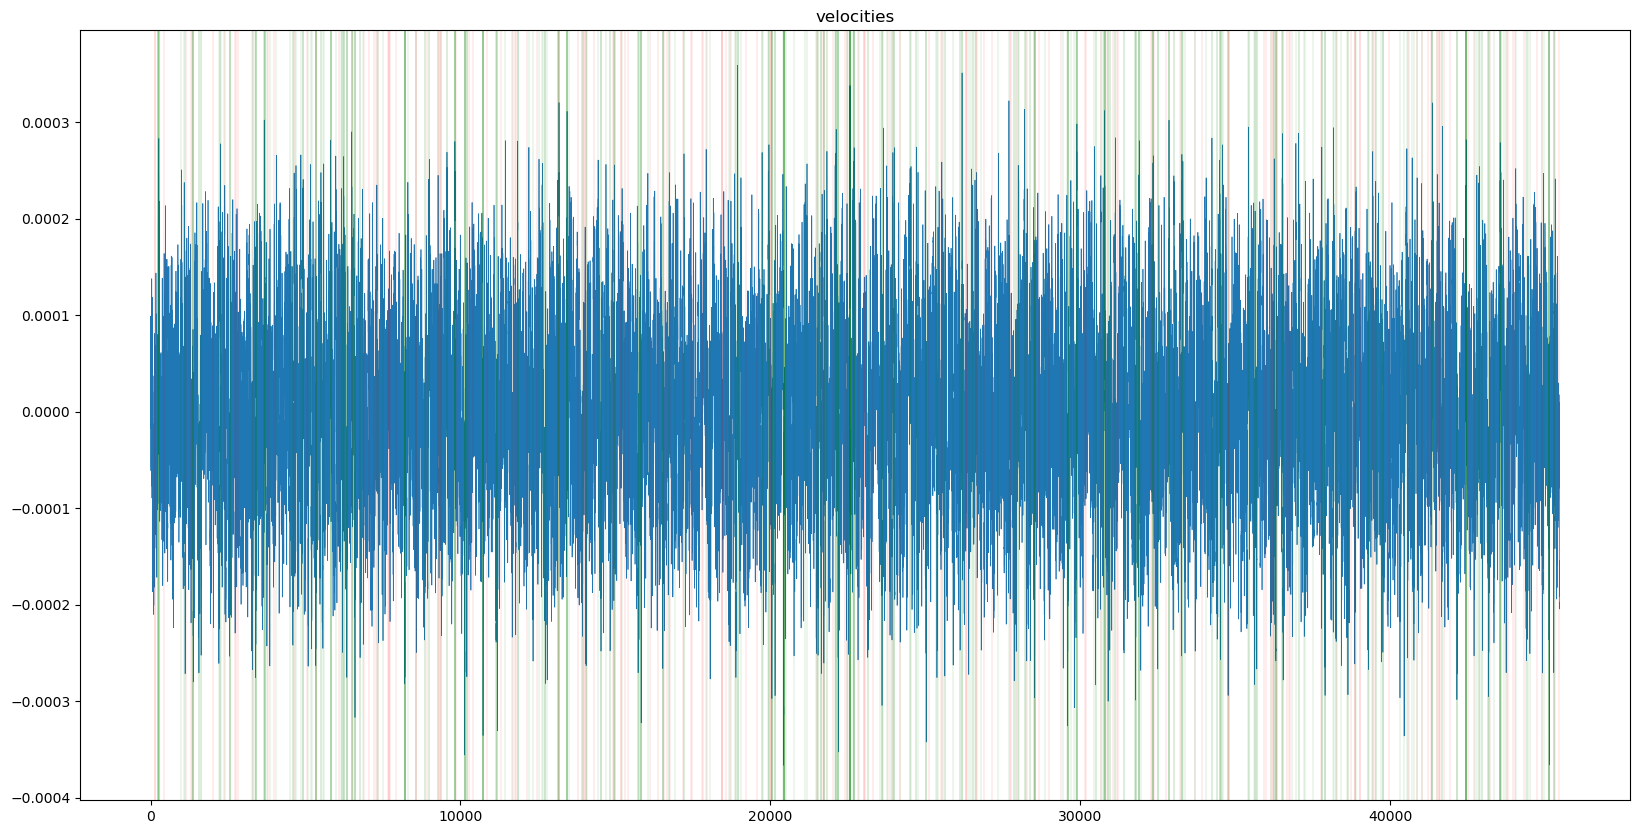

In [3]:
# Find spots where velocity is zero
import matplotlib.pyplot as plt

index_mult = 1#(timestep * sample_rate) * tao_c
x_c = 1

zero_idxs = []
high_idxs = []
for i in range(len(traces)):
    plt.figure(figsize=(20,10))
    # plt.plot([t * index_mult for t in range(len(positions[i]))], positions[i] * x_c, linewidth=0.5)
    plt.plot([t * index_mult for t in range(len(V_traces[i]))], V_traces[i], linewidth=0.5)

    tolerance = (.005*np.std(V_traces[i]))
    high_tolerance = (2.5*np.std(V_traces[i]))

    far_from_zero_indicies = np.where(abs(V_traces[i]) > high_tolerance)[0]
    close_to_zero_indices = np.where(abs(V_traces[i]) < tolerance)[0]

    print("zero idx: " + str(close_to_zero_indices))
    plt.title("velocities")
    # Draw vertical lines where values are close to zero
    for index in close_to_zero_indices:
        plt.axvline(x=index*index_mult, color='red', linestyle='-', linewidth=0.1)

    for index in far_from_zero_indicies:
        plt.axvline(x=index*index_mult, color='green', linestyle='-', linewidth=0.1)

    high_idxs.append(far_from_zero_indicies)
    zero_idxs.append(close_to_zero_indices)

In [4]:
def compute_msd(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd = [(time_trace[0]-time_trace[i])**2 for i in range(n)]
    return msd, lag_times

v at rand idx is -9.504686455430175e-05
v at rand idx is -6.593430205891584e-06
v at rand idx is -9.800835364257514e-05
v at rand idx is 0.00010322733859511225
v at rand idx is -1.4586381078164307e-05
v at rand idx is -2.301208620712178e-05
v at rand idx is 2.5445195450421267e-05
v at rand idx is -0.00010001073292057589
v at rand idx is -0.0001658356226488395
v at rand idx is 6.763399852406149e-06
v at rand idx is 0.00011711910214247329
v at rand idx is -3.169381017600761e-05
v at rand idx is -3.6261778256295153e-05
v at rand idx is -3.2759997673191236e-05
v at rand idx is -1.6228689553169614e-05
v at rand idx is -4.960672259964636e-05
v at rand idx is -8.179915754888745e-05
v at rand idx is 0.00012241481652377047
v at rand idx is -1.583280851240364e-05
v at rand idx is -0.00011569158179138544
v at rand idx is -4.576173713916845e-05
v at rand idx is -2.4570261657964617e-05
v at rand idx is -6.941645469619622e-05
v at rand idx is -0.00013016836462002694
v at rand idx is 3.60890613564705

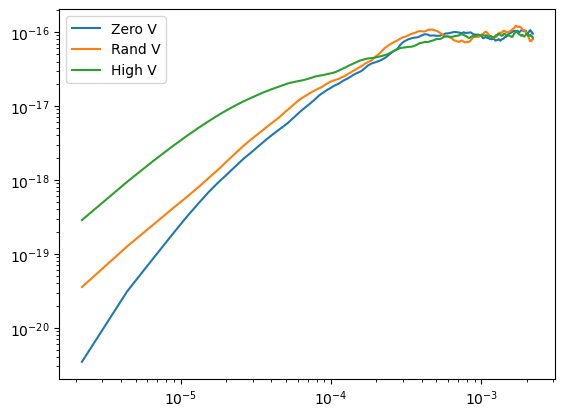

In [5]:
msd_len = 1000
lag_times = 0

import random

msds_zint = []
for i in range(len(traces)):
    for idx in zero_idxs[i]:
        if idx+msd_len < len(traces[i]):
            super_trace = traces[i][idx:idx+msd_len]
            msd, lag_times = compute_msd(super_trace, 1/fs)
            msds_zint.append(msd)

msds_rint = []
for i in range(len(traces)):
    for j in range(len(zero_idxs[i])):
        idx = random.randint(0,len(traces[i])-msd_len)
        print("v at rand idx is " + str(V_traces[i][idx]))
        reg_trace = traces[i][idx:idx+msd_len]
        msd2, lag_times = compute_msd(reg_trace, 1/fs)
        msds_rint.append(msd2)

msds_hint = []
for i in range(len(traces)):
    for idx in high_idxs[i]:
        if idx+msd_len < len(traces[i]):
            slow_trace = traces[i][idx:idx+msd_len]
            msd, lag_times = compute_msd(slow_trace, 1/fs)
            msds_hint.append(msd)

msds_zinta = np.mean(msds_zint, axis=0)
msds_rinta = np.mean(msds_rint, axis=0)
msds_hinta = np.mean(msds_hint, axis=0)

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
plt.plot(lag_times[1:], msds_hinta[1:], label="High V")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
        

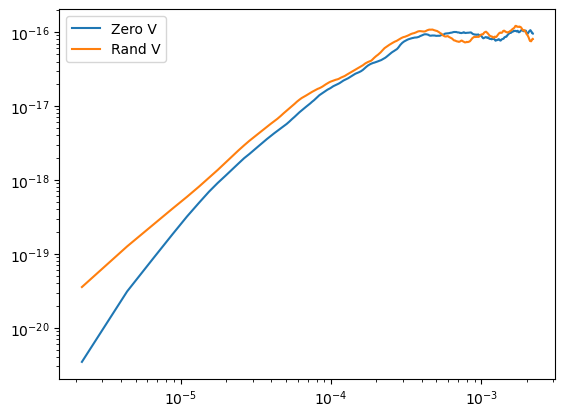

In [6]:

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
